# Connect to the drive repository

In [1]:
## mount to the drive
import os 
import sys 
import time
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive/MyDrive/NLP_PRO_ENSAE

/content/drive/MyDrive/NLP_PRO_ENSAE


# Useful libraries

In [3]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 13.5MB/s 
     |████████████████████████████████| 901kB 28.2MB/s 
     |████████████████████████████████| 3.0MB 63.7MB/s 
     |████████████████████████████████| 1.2MB 39.5MB/s 


In [4]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-h6tlw1ww
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-h6tlw1ww
  Created wheel for nlpaug: filename=nlpaug-1.1.3-cp37-none-any.whl size=837588 sha256=f4333d69f29ecb610097f086ef3fbca3eced9ae478aa2795b809957b85c0f381
  Stored in directory: /tmp/pip-ephem-wheel-cache-fufv3lyi/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [5]:
!pip install nltk
!pip install datasets

     |████████████████████████████████| 225kB 15.1MB/s 
     |████████████████████████████████| 112kB 30.3MB/s 
     |████████████████████████████████| 245kB 32.8MB/s 


In [6]:
import nltk
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time



from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords


import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig, BertForSequenceClassification, RobertaModel, RobertaTokenizer
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm
from random import shuffle
import random
import nlpaug.augmenter.word as naw

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
#from datasets import text_dataset, financialPhraseBankDataset

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

# Dataset part

## Data exploration

In [ ]:
## import the first dataframe (amazon-fine-food-review)
df = pd.read_csv('Reviews.csv')
print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


There are no missing values in score and reviews. So we check whether class are unbalanced or not.

It's common that users duplicate theirs comments and score to avoid loss time. So we will check if that's the case in this dataset and just keep the first comment among duplicates comments.

In [ ]:
df_final=df.drop_duplicates(subset=['UserId','ProfileName','Score','Time','Summary','Text'],keep='first')
print(df_final.shape)
print(df.shape)

(395200, 10)
(568454, 10)


Its common that HelpfulnessNumerator (Number of users who found the review helpful) can not be greater than HelpfulnessDenominator(Number of users who indicated whether they found the review helpful or not) So we will only keep rows that respect this condition.

In [ ]:
df_final=df_final[df_final['HelpfulnessNumerator']<=df_final['HelpfulnessDenominator']]
print(df_final.shape)


(395198, 10)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


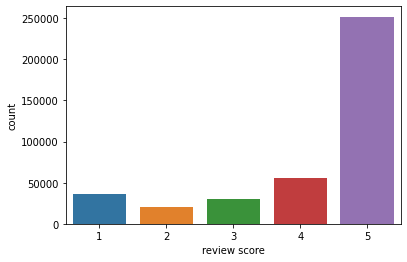

In [ ]:
sns.countplot(df_final.Score)
plt.xlabel('review score');

Classes are unbalanced we will try to fix this issue next. We are only interested in comments and the rank of product so we will only keep two columns of the dataset (score and Text). We make an assumption "the higher the rank, the better the reviews". The rank is between 1 and 5 so We're going to convert the dataset into negative, neutral and positive sentiment: 
- 0 if the rank is between 1 and 2 (negative);
- 1 if the rank is egual to 3 (neural);
- 2 if the rank is high than 3 (positive).


 

In [ ]:
df_final['sentiment'] = [2 if j>3 else 1 if j==3 else 0 for j in df_final['Score']]


In [ ]:
print(df_final.shape)
df_final.head()

(395198, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2


In [ ]:
##keeping the two columns of interest
data = df_final[['sentiment','Text']]
data.head()

,sentiment,Text
0,2,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,2,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,2,Great taffy at a great price. There was a wid...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


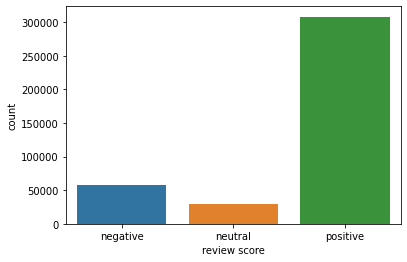

In [ ]:
## visualisation of the distribution of the sentiment
class_names = ['negative', 'neutral', 'positive']
ax=sns.countplot(data.sentiment)
plt.xlabel('review score')
ax.set_xticklabels(class_names);

## Data augmentation
In the last section we check that classes are unbalanced so in this section we will fix this issue by performing data augmentation. The data augmentation involve in these techniques:
- Synonym replacement (SR) Synonym replacement is a technique in which we replace a word by one of its synonyms. 
- Random Deletion (RD) In Random Deletion, we randomly delete a word if a uniformly generated number between 0 and 1 is smaller than a pre-defined threshold. 
- Random Swap (RS) In Random Swap, we randomly swap the order of two words in a sentence.
- Random Insertion (RI) Finally, in Random Insertion, we randomly insert synonyms of a word at a random position.

These techniques are presented in this [paper](https://arxiv.org/pdf/1901.11196.pdf)

In [ ]:
##split data on train, evaluation, test sets
df_train, df_test = train_test_split(df_final, test_size=0.25, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

In [ ]:
##keeping the two columns of interest
data = df_train[['sentiment','Text']]
data.head()

In [ ]:
## visualisation of the distribution of the sentiment
class_names = ['negative', 'neutral', 'positive']
ax=sns.countplot(data.sentiment)
plt.xlabel('review score')
ax.set_xticklabels(class_names);

In [ ]:
aug = naw.ContextualWordEmbsAug(model_path='bert-base-cased') # word will be replaced according to contextual embeddings calculation
aug_w2v = naw.ContextualWordEmbsAug(model_path='bert-base-cased',
                                    action="insert") #a new word will be injected to random position according to contextual word embeddings calculation

In [ ]:
def augment_text(df,samples=300,pr=0.2,classes=1):
    aug_w2v.aug_p=pr
    aug.aug_p=pr
    new_text=[]
    

    ##selecting the class samples
    df_n=df[df.sentiment==classes].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
            #p = random.random()
            #if p<0.5:
            text = df_n.iloc[i]['Text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
          #else:
            text1 = df_n.iloc[i]['Text']
            augmented_text = aug.augment(text1)
            new_text.append(augmented_text)
    
    ## dataframe
    new=pd.DataFrame({'Text':new_text,'sentiment':classes})
    #df=shuffle(df.append(new).reset_index(drop=True))
    return new #df

In [ ]:
##augmentation for the neutral class
#%%time
n_neutral = np.sum(df_train.sentiment==1)
tmp1 = augment_text(data,1000 )

In [ ]:
##augmentation for the negative class
#n_neg = np.sum(df_train.sentiment==0)
tmp2 = augment_text(data,1000,classes=0 )

In [ ]:
data_train.head()

In [ ]:
text=data.append(tmp1).reset_index(drop=True)
data_train=text.append(tmp2).reset_index(drop=True)

In [ ]:
print(data_train.shape)
print(data.shape)

In [ ]:
data_train.to_csv("df_train.csv")
df_test.to_csv("df_test.csv")
df_val.to_csv("df_val.csv")

In [ ]:
##read data
df_train = pd.read_csv('df_train.csv',index_col=0)
df_test = pd.read_csv('df_test.csv', index_col=0)
df_val = pd.read_csv('df_val.csv', index_col=0)

# Read train, test and evaluation dataset

In [ ]:
##read data
df_train = pd.read_csv('df_train.csv',index_col=0)
df_val = pd.read_csv('df_val.csv')

# Sentiment analysis with BERT

## preparing data

Machine don't really understand the raw text so we have to convert it into number to be comprehensible by the machine. In the case of BERT we have three principal obligations (read more [here](https://github.com/google-research/bert)):

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

This can be done by using the BertTokenizer of tranformers class. For this task we will use the **BERT base cased model** because we matter about accent and case (it is usefull to understand the review).

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
## load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We have to define the maximum lenght that will be considered in each review. So we will plot the distribution of tokens in the dataset for each review.

In [ ]:
token_lens = []

for txt in df_final.Text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


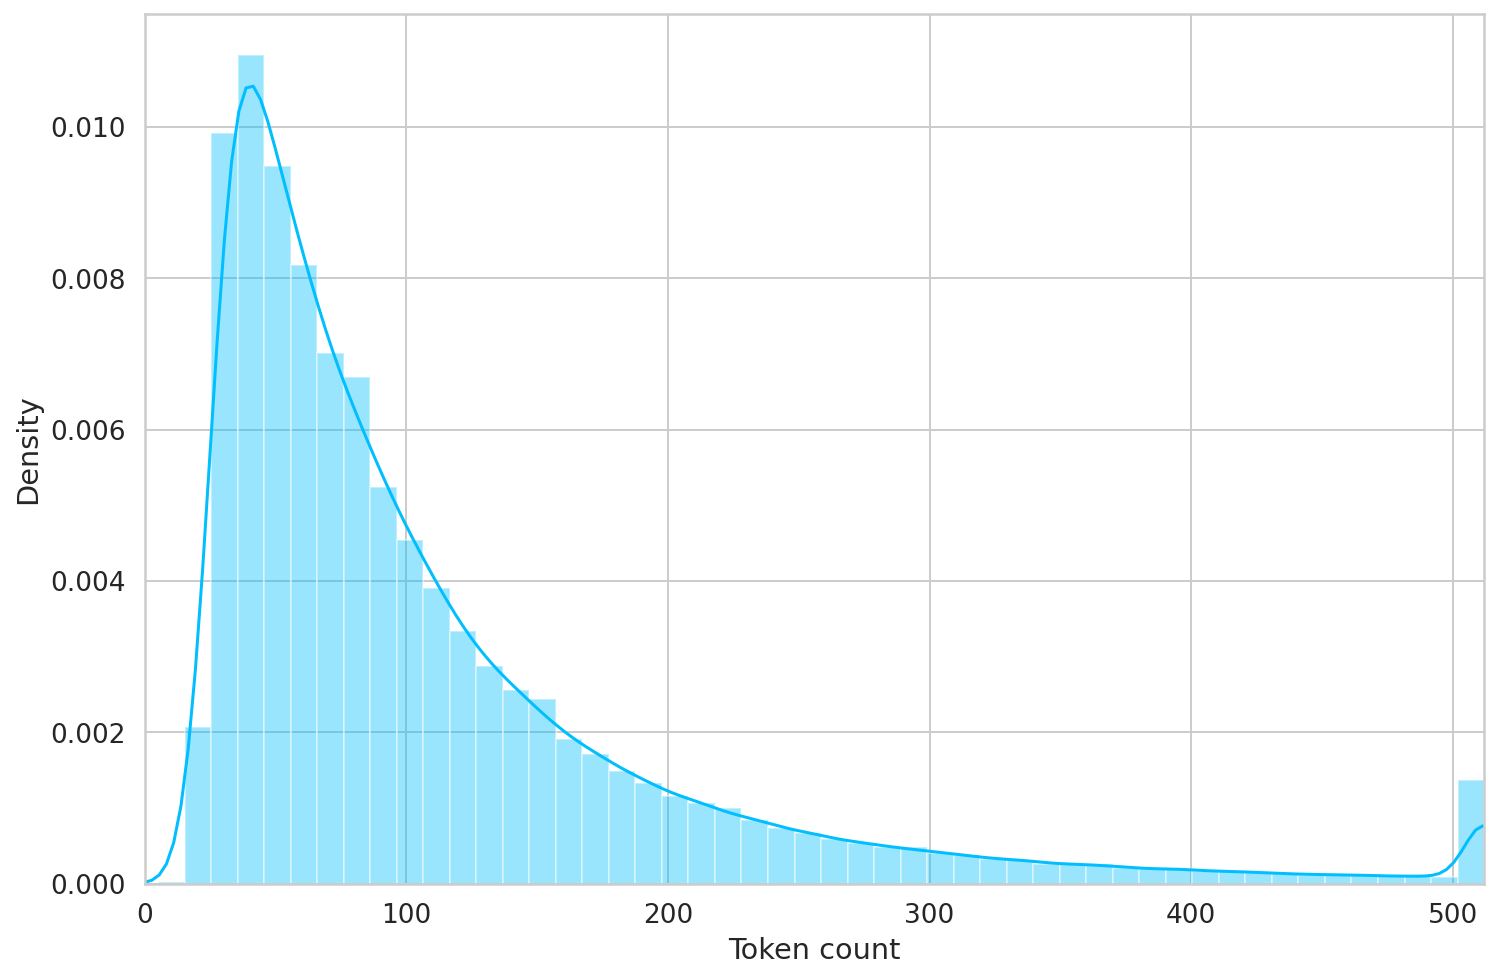

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

We will take the maximum length equal to 200 due to computationnal ressources.

In [ ]:
MAX_LEN = 200

In [ ]:
class Data(Dataset):

  def __init__(self, reviews, targets, tokenizer=tokenizer, max_len=MAX_LEN):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def load_batch(df, batch_size=32,max_len=MAX_LEN, tokenizer = tokenizer):
  tmp = Data(df.Text.to_numpy(), 
             df.sentiment.to_numpy(), 
             tokenizer, 
             max_len)
  return DataLoader(tmp,  batch_size=batch_size, shuffle= True)

In [ ]:
BATCH_SIZE = 32

train_data_loader = load_batch(df_train)
val_data_loader = load_batch(df_val)


## BERT Model
In this section we will perform a sentiment analysis with BERT base cased pretrained model.

The bert_model have two outputs: last_hidden_state, pooled_output. So for this task we will only keep the pooled_output and add a dense layer in the top of the class.

In [ ]:
## This is the pytorch class for the BERT sentiment analysis
class sentiment_analysis(nn.Module):
  def __init__(self, n_classes):
    super(sentiment_analysis, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    tmp = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = tmp[1]
    output = self.drop(pooled_output)
    #output = self.out(output)
    return self.out(output) #F.softmax(output, dim=1)

In [ ]:
n_classes=3

In [ ]:
model = sentiment_analysis(n_classes)
model = model.to(device)

## Training

In [ ]:
# We set the number of epochs, the optimzer, the loss and the scheduler
#class_weights = torch.tensor([np.sum(df_train['sentiment']==0)/len(df_train), np.sum(df_train['sentiment']==1)/len(df_train), np.sum(df_train['sentiment']==2)/len(df_train)])
class_weights = torch.tensor([0.2,0.5,0.3])
EPOCHS = 4
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters() , lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.float()).to(device)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
## the training function
def train(model,
          data_loader, 
          n_examples,
          device = device,
          optimizer= optimizer, 
          loss=loss_fn,
          scheduler = scheduler):
  model.train()
  losses=[]
  correct_predictions=0
  for data in data_loader:

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())
    correct_predictions += torch.sum(preds == targets)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)



In [ ]:
## the evaluation function



def eval(model,
          data_loader, 
          n_examples,
          device = device
         ):
  model.eval()
  losses=[]
  correct_predictions=0
  with torch.no_grad():
    for data in data_loader:

      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)

      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())
      correct_predictions += torch.sum(preds == targets)
      
      
  return correct_predictions.double() / n_examples, np.mean(losses)



In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train(model, train_data_loader, len(df_train))
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval(model, val_data_loader, len(df_val)) 
  print(f'validation accuracy {val_acc} validation loss {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)



  
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

epoch1/4
--------------------
train accuracy 0.8849259981757535 train loss 0.3246013444858676
validation accuracy 0.9068218623481781 validation loss 0.2705955683613206
epoch2/4
--------------------
train accuracy 0.9176425941584165 train loss 0.23690500151378693
validation accuracy 0.9030161943319838 validation loss 0.269703556250279
epoch3/4
--------------------
train accuracy 0.9417339662714133 train loss 0.1761566487464704
validation accuracy 0.906255060728745 validation loss 0.35198567576819206
epoch4/4
--------------------
train accuracy 0.9624032117390928 train loss 0.12518736402338773
validation accuracy 0.9020850202429149 validation loss 0.4120366426657975
CPU times: user 4h 28min 18s, sys: 2h 43min 42s, total: 7h 12min 1s
Wall time: 7h 10min 18s


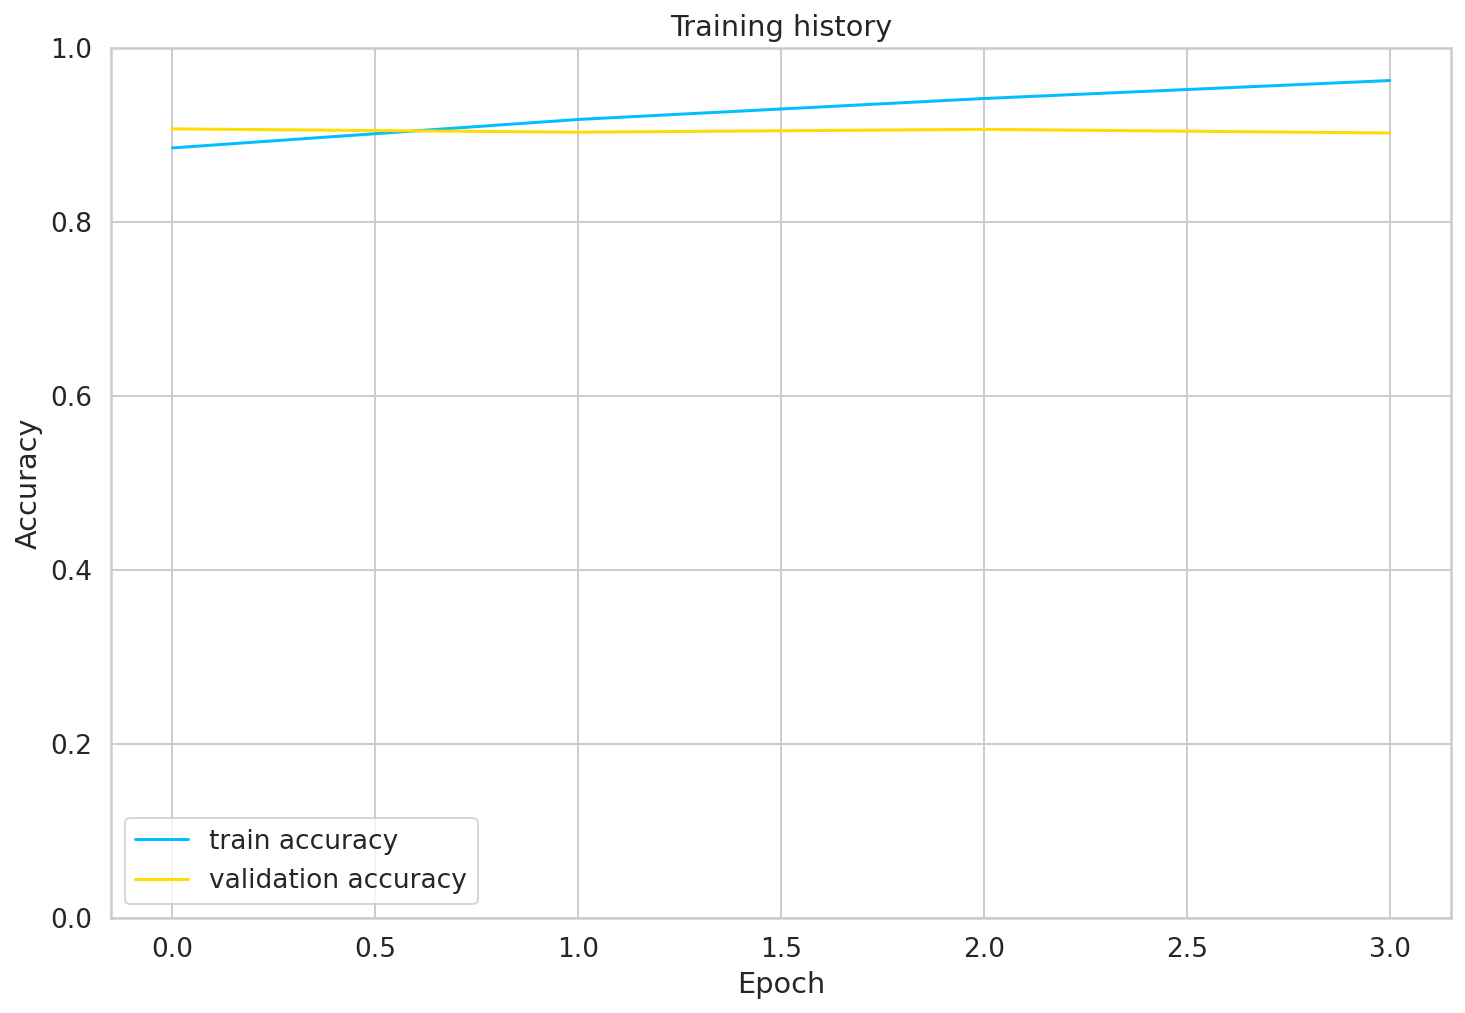

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

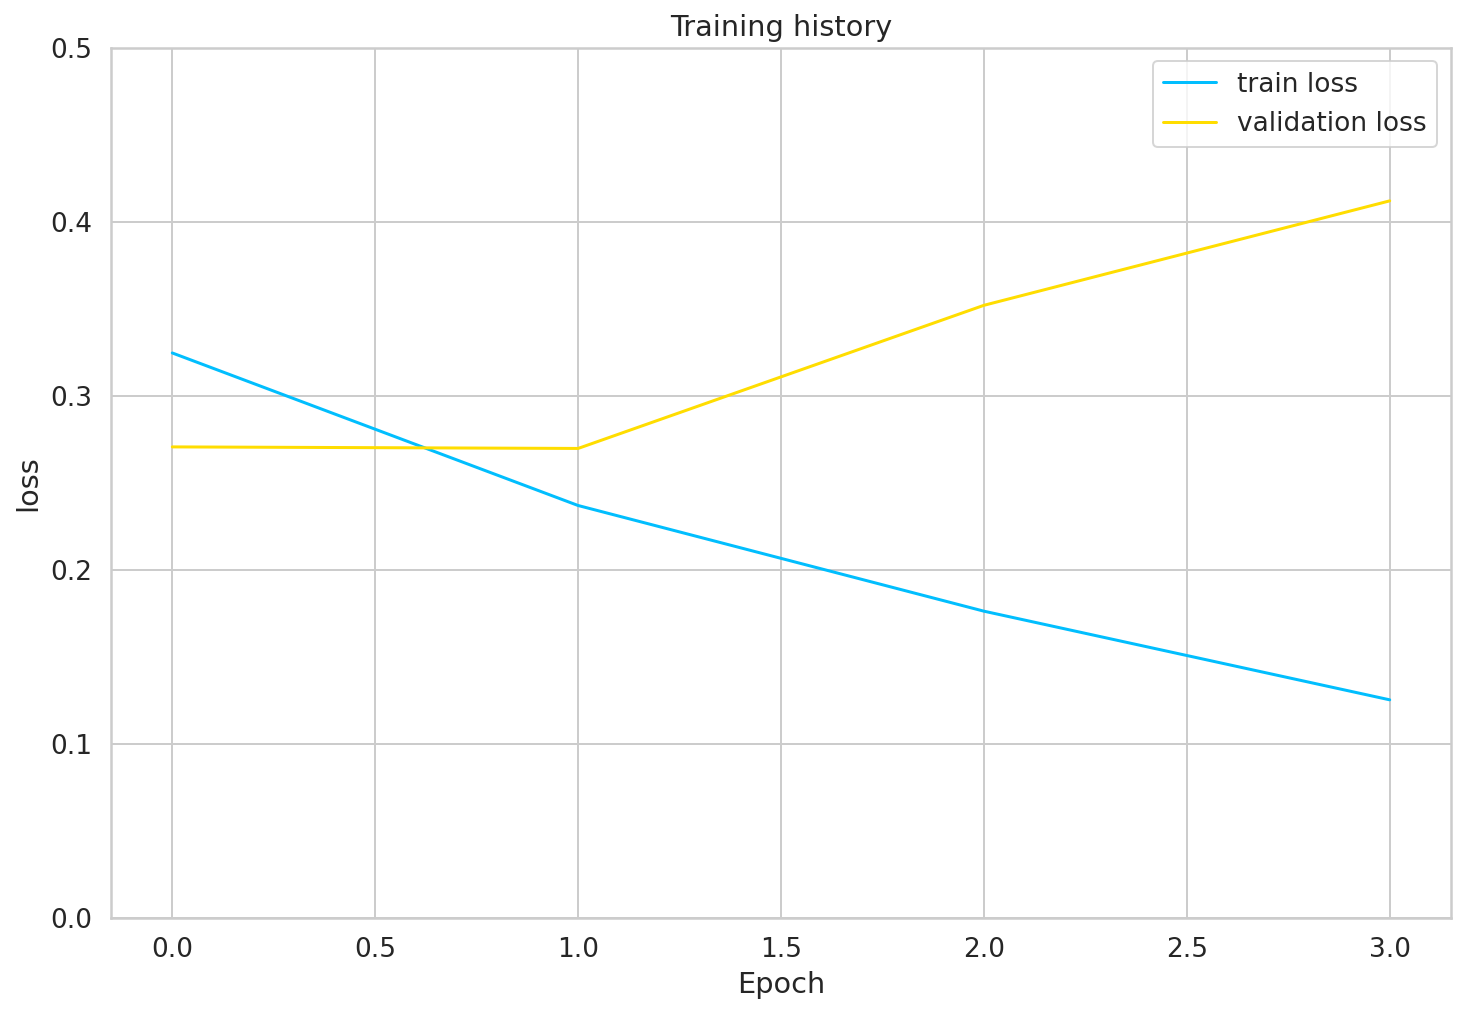

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

# Sentiment analysis with Roberta


## preparing dataloader

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
MAX_LEN=200

In [ ]:
class Roberta_Data(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=200):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Text
        self.targets = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            truncation=True,
            padding='max_length',
            #strategy = 'truncation',
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'text': text,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:

def load_batch2(df, batch_size=32,max_len=MAX_LEN, tokenizer = tokenizer):
  tmp = Roberta_Data(df, 
             tokenizer, 
             max_len)
  return DataLoader(tmp,  batch_size=batch_size, shuffle= True)

In [ ]:
BATCH_SIZE = 32

train_data_loader = load_batch2(df_train)
#val_data = df_val[['sentiment','Text']]
val_data_loader = load_batch2(df_val)
#test_data = df_test[['sentiment','Text']]
#test_data_loader = load_batch2(df_test)

##Roberta model

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self,n_classes=3):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model = model.to(device)

## training

In [ ]:
# We set the number of epochs, the optimzer, the loss and the scheduler
class_weights = torch.tensor([0.3,0.5,0.2])
#class_weights = torch.tensor([np.sum(df_train['sentiment']==0)/len(df_train), np.sum(df_train['sentiment']==1)/len(df_train), np.sum(df_train['sentiment']==2)/len(df_train)])
EPOCHS = 4
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters() , lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.float()).to(device)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_ro(model,
          dataloader=train_data_loader,
          n_examples=df_train.shape[0], 
          device = device,
          optimizer= optimizer, 
          loss=loss_fn,
          scheduler = scheduler):
    losses = []
    n_correct = 0
    #nb_tr_steps = 0
    #nb_tr_examples = 0
    model.train()
    for _,data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        tr_loss = loss(outputs, targets)
        losses.append(tr_loss.item())
        _, preds = torch.max(outputs.data, dim=1)
        n_correct += (preds==targets).sum()

        optimizer.zero_grad()
        tr_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return n_correct.double() / n_examples, np.mean(losses)

In [ ]:

## the evaluation function

def eval_ro(model,
          dataloader=val_data_loader, 
          n_examples= df_val.shape[0],
          loss=loss_fn,
          device = device
         ):
  model.eval()
  losses=[]
  n_correct=0
  with torch.no_grad():
    for _,data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        tr_loss = loss(outputs, targets)
        losses.append(tr_loss.item())
        _, preds = torch.max(outputs.data, dim=1)
        n_correct += (preds==targets).sum()

    return n_correct.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train_ro(model)
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval_ro(model) 
  print(f'validation accuracy {val_acc} validation loss {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_ro.bin')
    best_accuracy = val_acc

epoch1/4
--------------------
train accuracy 0.8947463032377047 train loss 0.3635849591381697
validation accuracy 0.9069838056680162 validation loss 0.32508595313133737
epoch2/4
--------------------
train accuracy 0.9175826736529538 train loss 0.2900439301491995
validation accuracy 0.9067004048582996 validation loss 0.3157400929735771
epoch3/4
--------------------
train accuracy 0.9352392492626449 train loss 0.23828104274704756
validation accuracy 0.9097975708502024 validation loss 0.34526774603716665
epoch4/4
--------------------
train accuracy 0.9511481434630058 train loss 0.19384594817073098
validation accuracy 0.9119635627530365 validation loss 0.42616662187525917
CPU times: user 4h 20min 32s, sys: 2h 36min 14s, total: 6h 56min 47s
Wall time: 6h 56min 2s


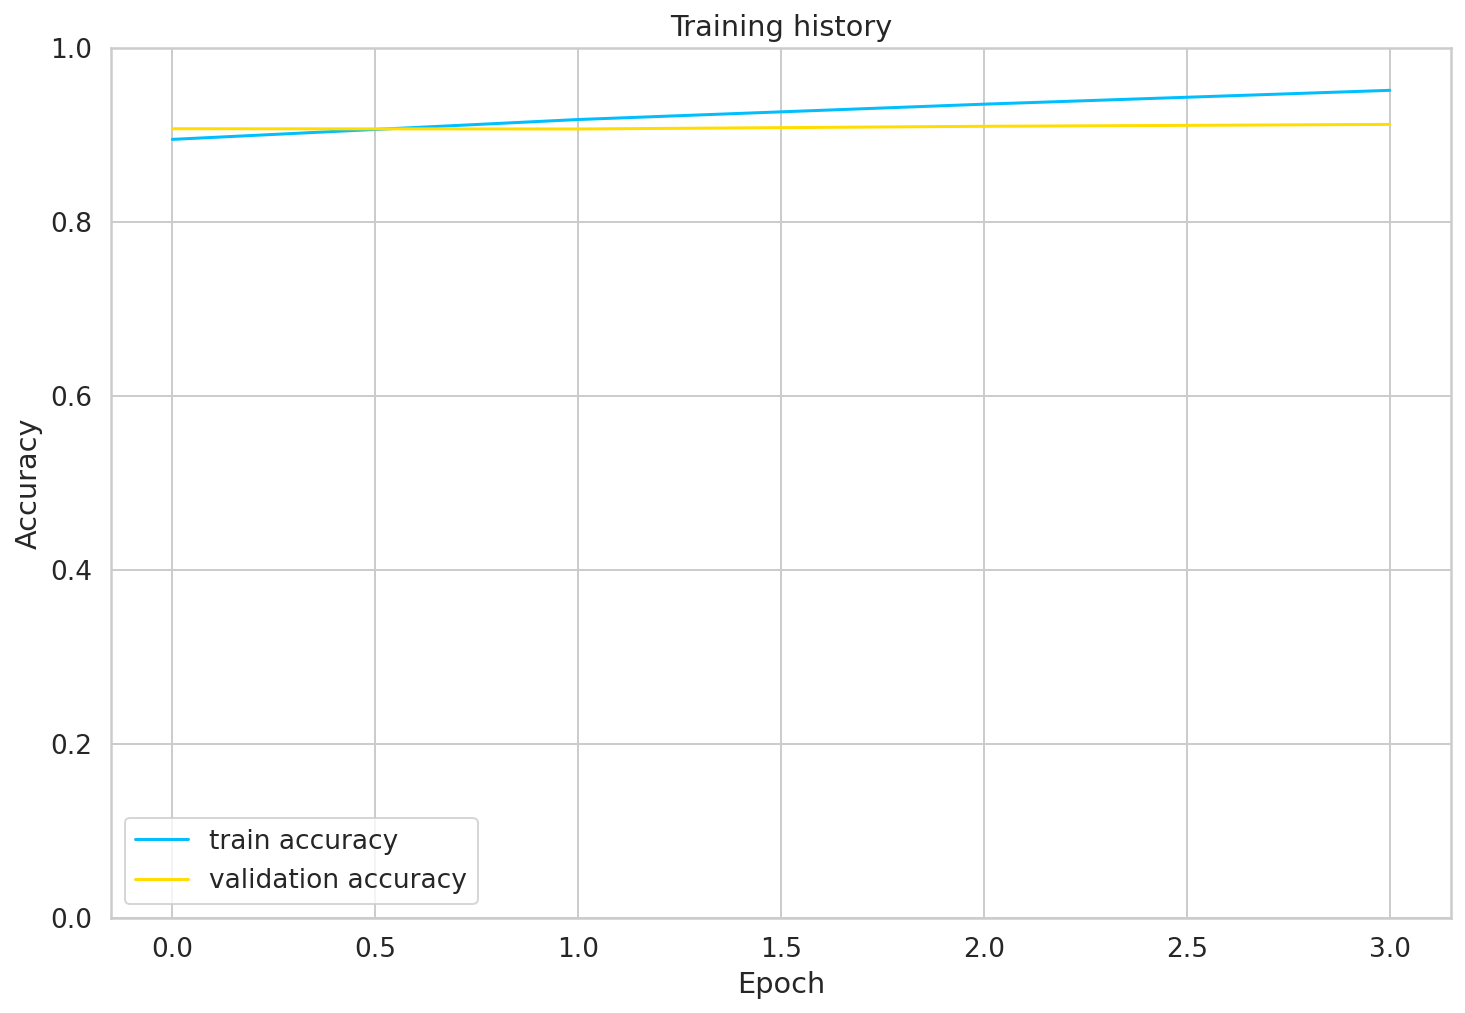

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

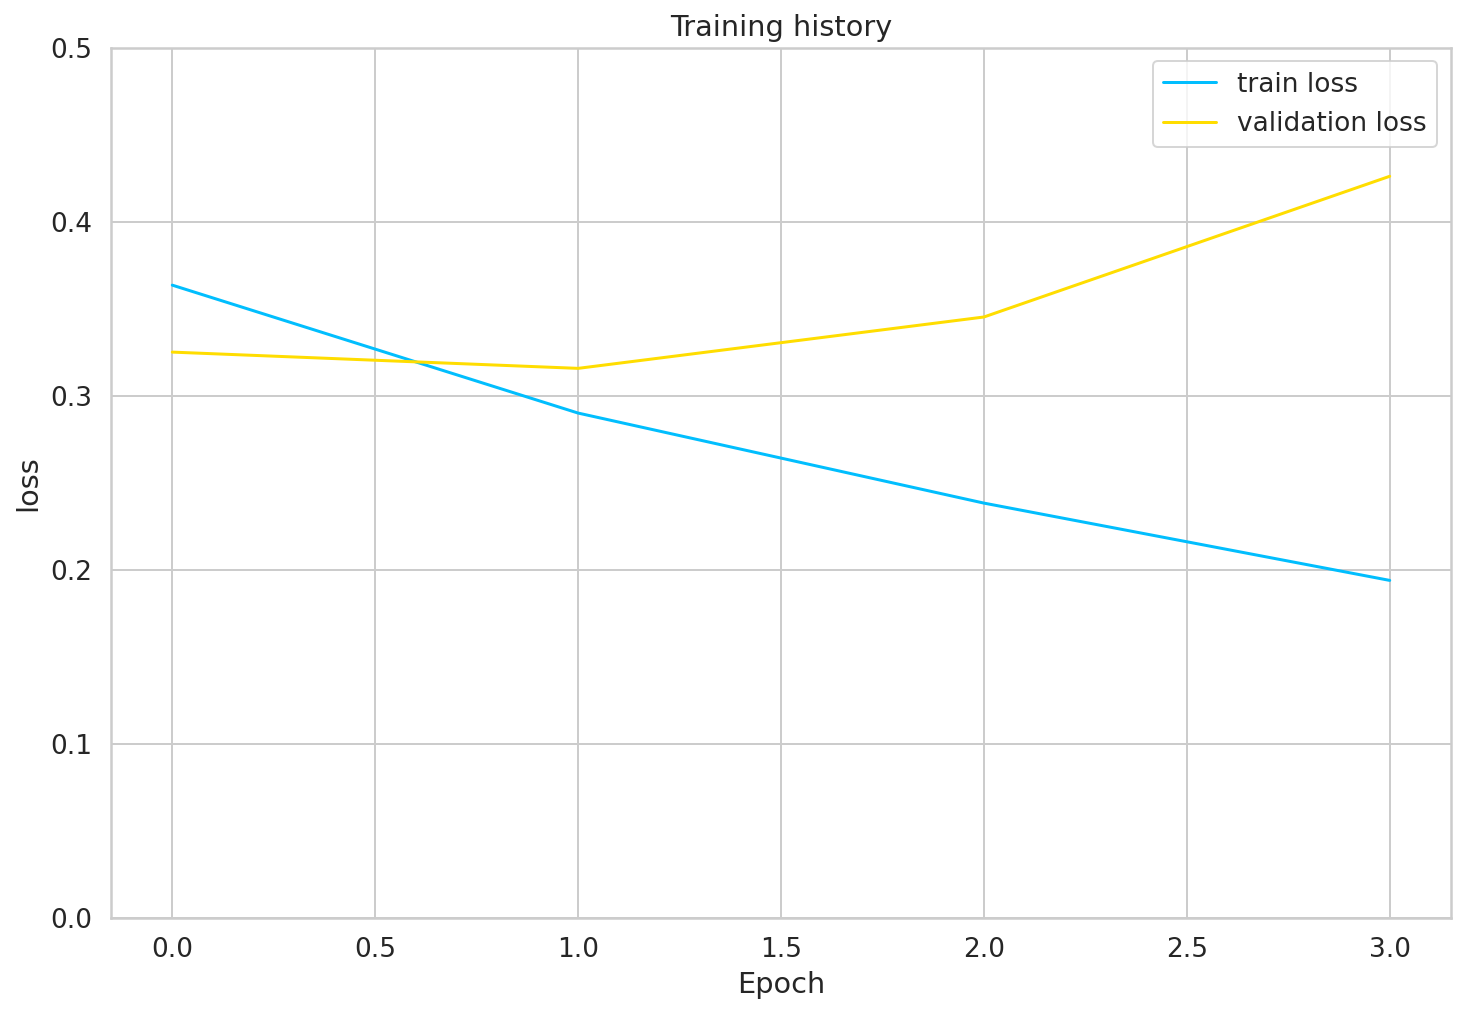

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

# Sentiment analysis with Character BERT


## download and set the model

In [ ]:
!python character-bert/download.py --model='all'

28/04/2021 08:35:45 - INFO - download.py -   Path pretrained-models/general_character_bert already exists.
28/04/2021 08:35:45 - INFO - download.py -   Skipped download of general_character_bert model.
28/04/2021 08:35:45 - INFO - download.py -   Path pretrained-models/medical_character_bert already exists.
28/04/2021 08:35:45 - INFO - download.py -   Skipped download of medical_character_bert model.
28/04/2021 08:35:45 - INFO - download.py -   Path pretrained-models/general_bert already exists.
28/04/2021 08:35:45 - INFO - download.py -   Skipped download of general_bert model.
28/04/2021 08:35:45 - INFO - download.py -   Path pretrained-models/medical_bert already exists.
28/04/2021 08:35:45 - INFO - download.py -   Skipped download of medical_bert model.
28/04/2021 08:35:45 - INFO - download.py -   Path pretrained-models/bert-base-uncased already exists.
28/04/2021 08:35:45 - INFO - download.py -   Skipped download of bert-base-uncased model.


In [ ]:
cd character-bert

/content/drive/My Drive/NLP_PRO_ENSAE/character-bert


In [ ]:
#from modeling.character_bert import CharacterBertModel
from utils.character_cnn import CharacterIndexer
from modeling.character_bert import CharacterBertModel

In [ ]:
def set_model(name='./pretrained-models/general_character_bert/', n_classes=3):
  """"
  name: represent the name of model used on character_bert_model
  n_classes: the number of classes
  """
  config = BertConfig.from_pretrained('bert-base-uncased', num_labels=n_classes)
  model = BertForSequenceClassification(config=config)

  #now replace bert with character bert embeddings which was downloaded
  character_bert_model = CharacterBertModel.from_pretrained(name)
  model.bert = character_bert_model
  return model

## Preparing dataloader

We will keep 30% of train dataset shape because of computationals ressources.

In [ ]:
df_train_n,_ = train_test_split(df_train, test_size=0.97, stratify=df_train['sentiment'] )
df_val_n,_ = train_test_split(df_val, test_size=0.97, stratify=df_val['sentiment'] )

In [ ]:
print(df_train_n.shape)
print(df_val_n.shape)

(9011, 2)
(1482, 12)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train = df_train_n['Text'].tolist()
tokenized_train = [tokenizer.basic_tokenizer.tokenize(text) for text in X_train] #have used basic tokenizer, other tokenizers can also be used

X_val = df_val_n['Text'].tolist()
tokenized_val = [tokenizer.basic_tokenizer.tokenize(text) for text in X_val]

In [ ]:
indexer = CharacterIndexer()
tensor_train = indexer.as_padded_tensor(tokenized_train, maxlen=200)
tensor_val = indexer.as_padded_tensor(tokenized_val, maxlen=200)

In [ ]:
batch_size = 10

y_train, y_val = torch.tensor(df_train_n['sentiment'].values),  torch.tensor(df_val_n['sentiment'].values)
train_data = torch.utils.data.TensorDataset(tensor_train, y_train)
train_dataloader = DataLoader(train_data,batch_size=batch_size)

val_data = torch.utils.data.TensorDataset(tensor_val, y_val)
val_dataloader = DataLoader(val_data,batch_size=batch_size)

## training

In [ ]:
def train_char(model, 
               dataloader,
               nb_examples ):
  model.train()
  tr_loss = []
  correct = 0
  for  batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_labels = batch

    optimizer.zero_grad()
    outputs = model(b_input_ids)[0]
    loss = loss_fn(outputs,b_labels)
    tr_loss.append(loss.item())
    _,prediction = torch.max(outputs,dim=1)
    correct+=(prediction==b_labels).sum().item() 
    
    loss.backward()

    optimizer.step()
  return correct/nb_examples, np.mean(tr_loss)
    

In [ ]:
def eval_char(model, 
               dataloader,
               nb_examples ):
  model.eval()
  tr_loss = []
  correct = 0
  with torch.no_grad():
    for  batch in dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_labels = batch

      optimizer.zero_grad()
      outputs = model(b_input_ids)[0]
      loss = loss_fn(outputs,b_labels)
      tr_loss.append(loss.item())
      _,prediction = torch.max(outputs,dim=1)
      correct+=(prediction==b_labels).sum().item() 
      
  return correct/nb_examples, np.mean(tr_loss)
    

### general character BERT

In [ ]:
## The characterBERT model

model = set_model()
model = model.to(device)

In [ ]:
#this is just to add extra decay and need not be added compulsorily
class_weights = torch.tensor([0.35,0.4,0.25])
#class_weights = torch.tensor([np.sum(df_train_n['sentiment']==0)/len(df_train_n), np.sum(df_train_n['sentiment']==1)/len(df_train_n), np.sum(df_train_n['sentiment']==2)/len(df_train_n)])
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

#define loss
loss_fn = nn.CrossEntropyLoss(weight=class_weights.float()).to(device)
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)
EPOCHS = 15


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train_char(model,dataloader= train_dataloader,nb_examples = df_train_n.shape[0])
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval_char(model,dataloader= val_dataloader,nb_examples = df_val_n.shape[0]) 
  print(f'validation accuracy {val_acc} validation loss {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_char.bin')
    best_accuracy = val_acc

epoch1/15
--------------------
train accuracy 0.8081234047275552 train loss 0.6234193520079431
validation accuracy 0.8333333333333334 validation loss 0.47111024177514466
epoch2/15
--------------------
train accuracy 0.8820330706913772 train loss 0.3740360639605283
validation accuracy 0.8049932523616734 validation loss 0.513550514549067
epoch3/15
--------------------
train accuracy 0.9235378981245145 train loss 0.24846509427137822
validation accuracy 0.8387314439946019 validation loss 0.5331858734869017
epoch4/15
--------------------
train accuracy 0.952169570524914 train loss 0.16175506863290828
validation accuracy 0.8596491228070176 validation loss 0.6411717585600513
epoch5/15
--------------------
train accuracy 0.9735878370880036 train loss 0.09968457448370073
validation accuracy 0.8549257759784076 validation loss 0.6484917086235016
epoch6/15
--------------------
train accuracy 0.9773610032182888 train loss 0.07716818441889309
validation accuracy 0.8515519568151148 validation loss 0.

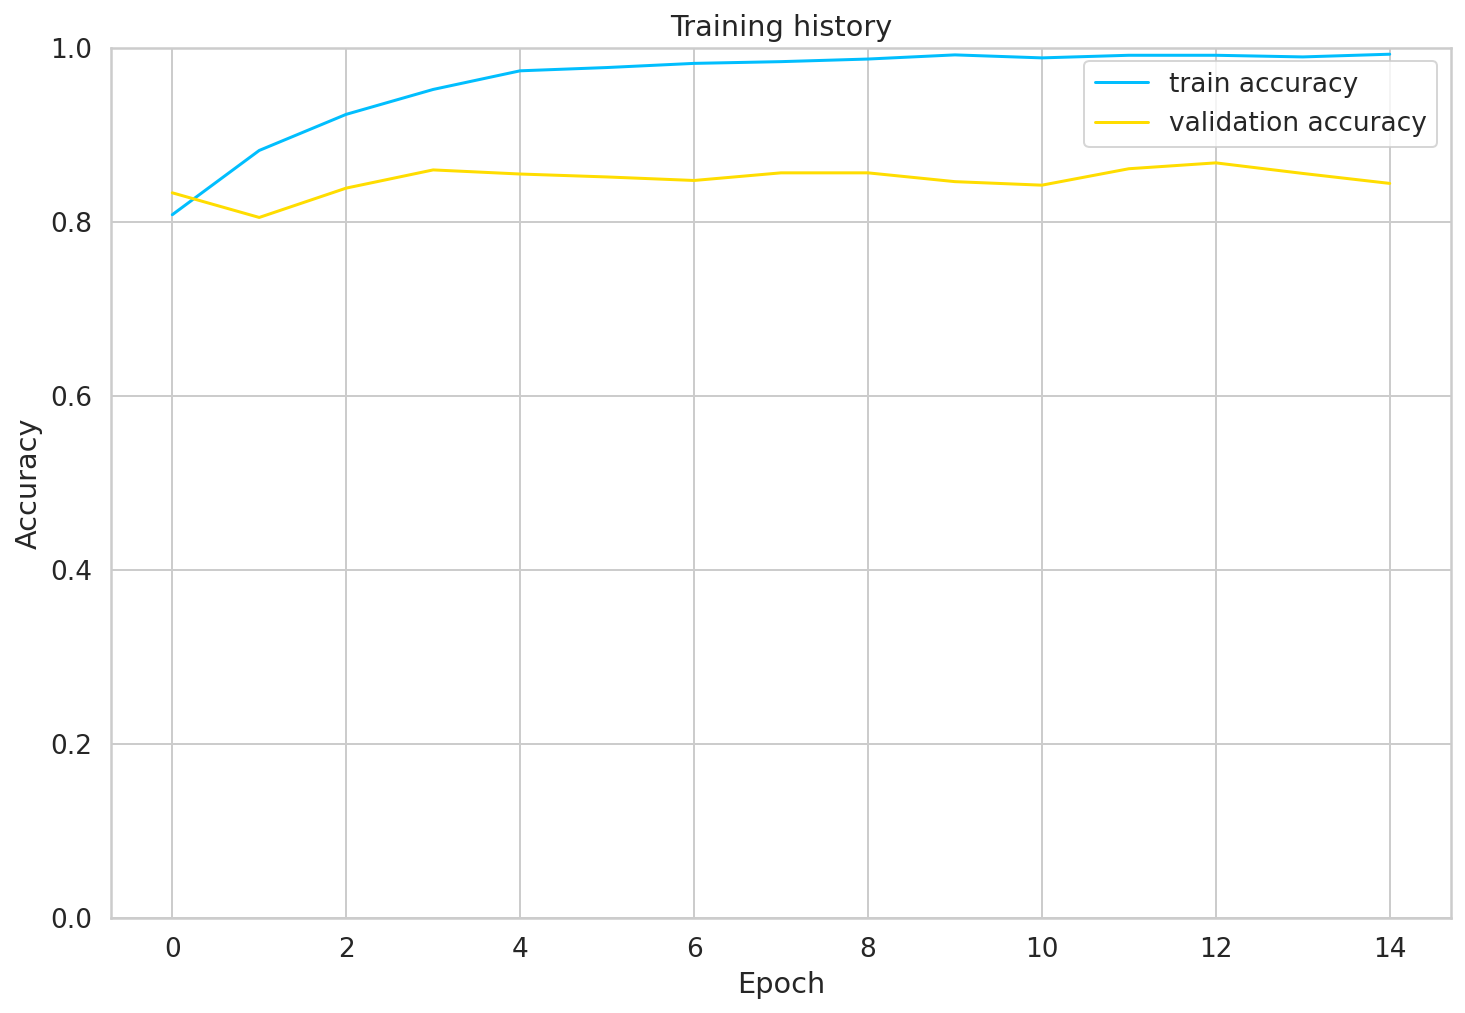

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

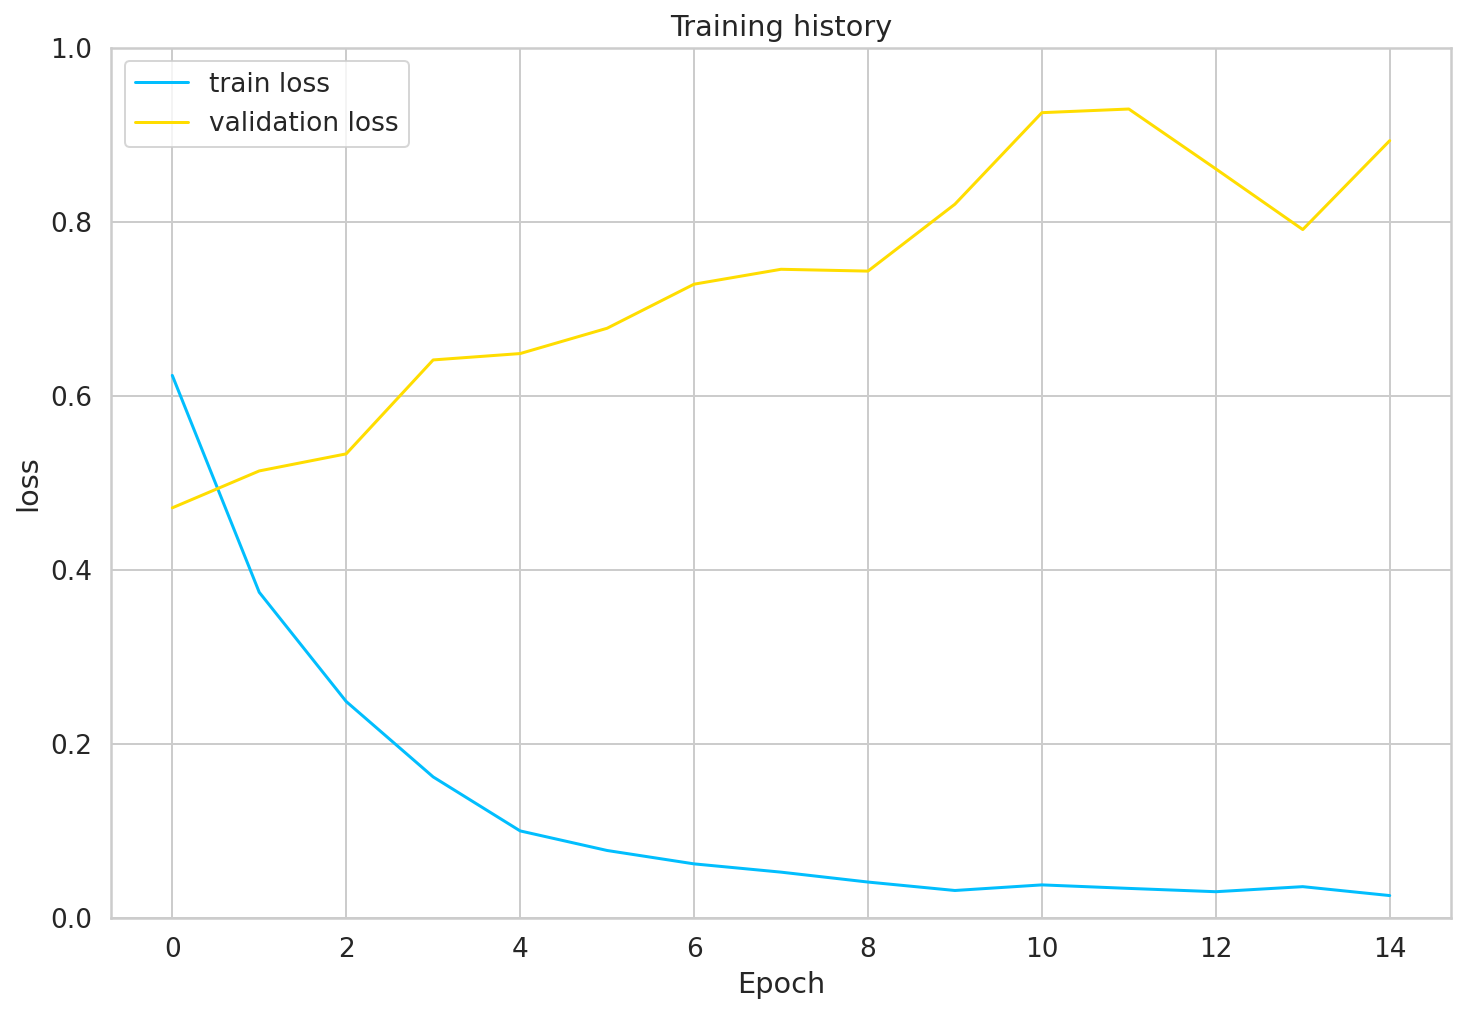

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### medical characterBERT

In [ ]:
model = set_model(name='./pretrained-models/medical_character_bert/')
model = model.to(device)

In [ ]:
#this is just to add extra decay and need not be added compulsorily
class_weights = torch.tensor([0.3,0.5,0.2])
#class_weights = torch.tensor([np.sum(df_train_n['sentiment']==0)/len(df_train_n), np.sum(df_train_n['sentiment']==1)/len(df_train_n), np.sum(df_train_n['sentiment']==2)/len(df_train_n)])
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

#define loss
loss_fn = nn.CrossEntropyLoss(weight=class_weights.float()).to(device)
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)
EPOCHS = 15


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train_char(model,dataloader= train_dataloader,nb_examples = df_train_n.shape[0])
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval_char(model,dataloader= val_dataloader,nb_examples = df_val_n.shape[0]) 
  print(f'validation accuracy {val_acc} validation loss {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_med_char.bin')
    best_accuracy = val_acc

epoch1/15
--------------------
train accuracy 0.776828320941072 train loss 0.8298014987697887
validation accuracy 0.8043184885290149 validation loss 0.6522058932073165
epoch2/15
--------------------
train accuracy 0.8268782599045611 train loss 0.6017882776490006
validation accuracy 0.8211875843454791 validation loss 0.5264842207699814
epoch3/15
--------------------
train accuracy 0.8734879591610254 train loss 0.44296816403372524
validation accuracy 0.7995951417004049 validation loss 0.6089950773439952
epoch4/15
--------------------
train accuracy 0.9102208411940961 train loss 0.32900708488719393
validation accuracy 0.844804318488529 validation loss 0.6069782557178464
epoch5/15
--------------------
train accuracy 0.9387415381200754 train loss 0.23188448944511078
validation accuracy 0.8529014844804319 validation loss 0.6296464632977825
epoch6/15
--------------------
train accuracy 0.9581622461436022 train loss 0.16967573187762083
validation accuracy 0.8623481781376519 validation loss 0.6

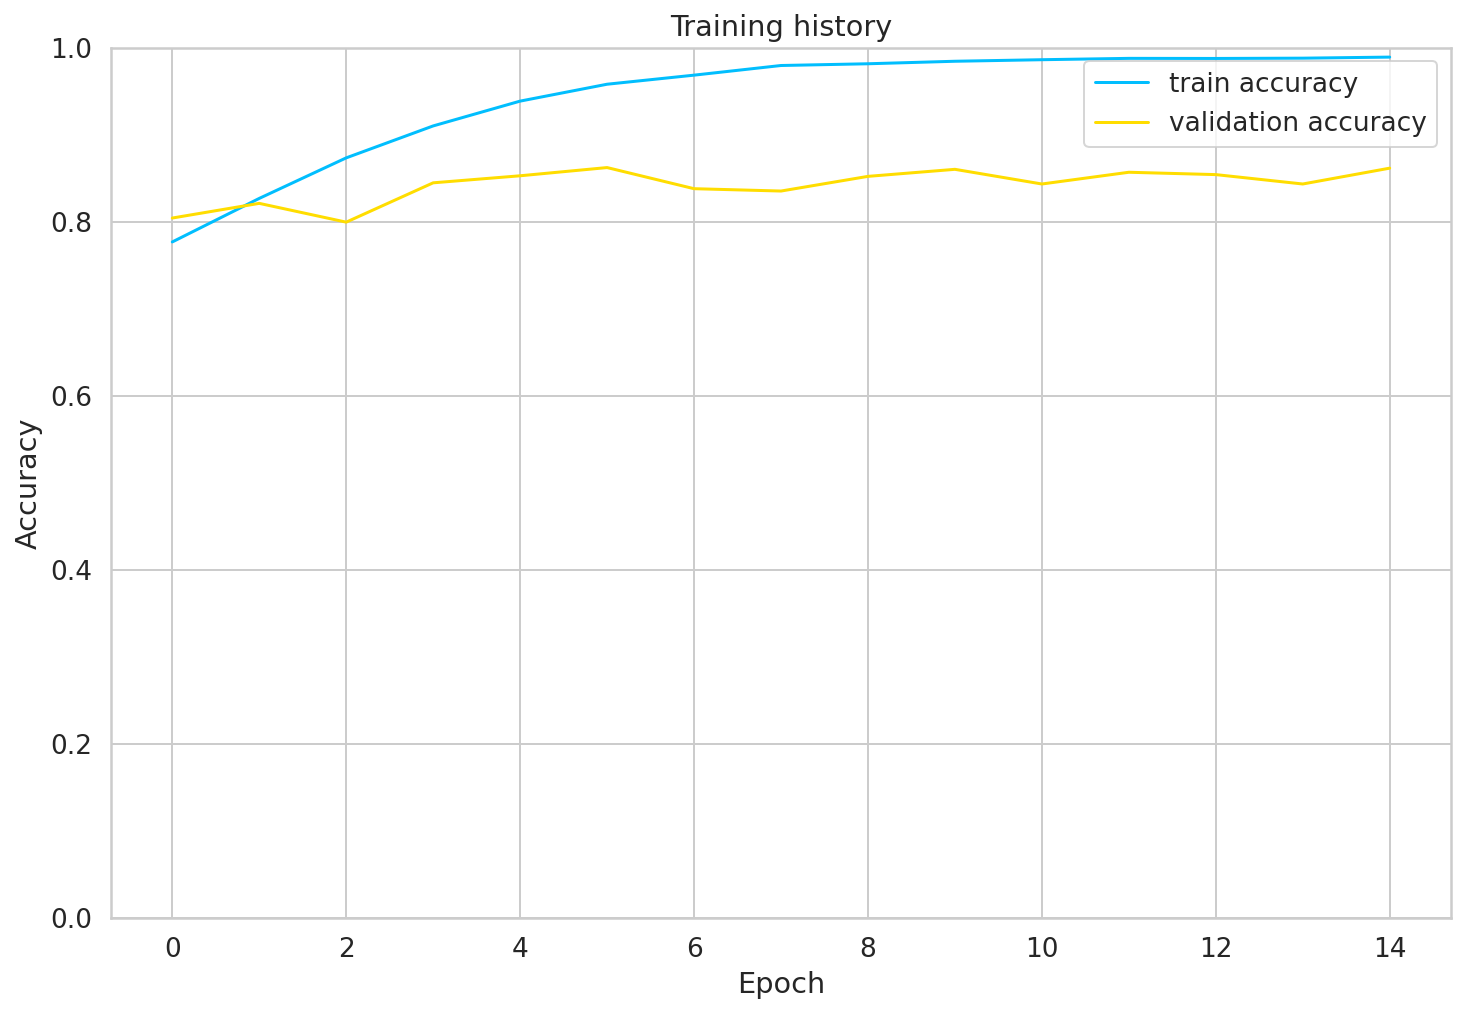

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

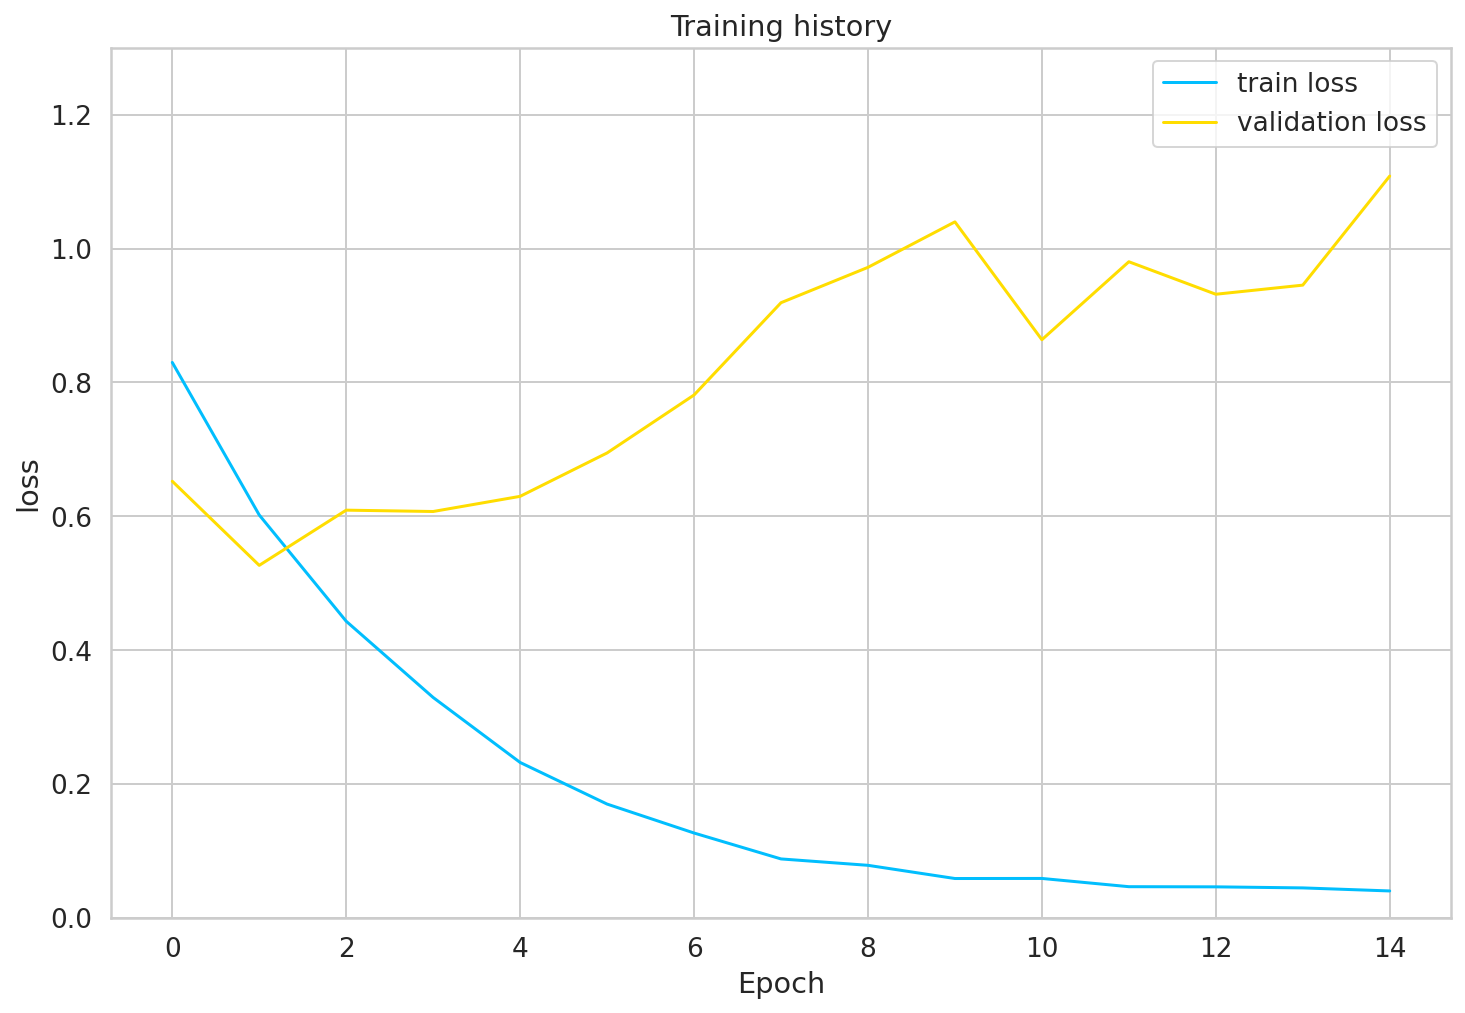

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.3]);

# Evaluation

## BERT and Roberta

In [ ]:
df_test = pd.read_csv('df_test.csv') ##test data for BERT and ROBERTA


In [ ]:
## load the BERT tokenizer
tokenizer_b = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
##load roberta tokenizer
tokenizer_r = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
## test batch for BERT model
test_data_loader_b = load_batch(df_test, tokenizer= tokenizer_b)
##test batch for Roberta model
test_data_loader_r = load_batch2(df_test, tokenizer= tokenizer_r)

In [ ]:
## Load BERT model
n_classes=3
model_bert = sentiment_analysis(n_classes)
model_bert.load_state_dict(torch.load('best_model_state.bin'))
model_bert = model_bert.to(device)
## Load ROBERTA model
model_ro = RobertaClass(n_classes)
model_ro.load_state_dict(torch.load('best_model_state_ro.bin'))
model_ro = model_ro.to(device)

In [ ]:
##accuracy on test set with BERT
test_acc_b, _ = eval(
  model_bert,
  test_data_loader_b,
  len(df_test),
)

##accuracy on test set with roberta
test_acc_ro, _ = eval_ro(
  model_ro,
  test_data_loader_r,
  len(df_test),
)

print(test_acc_b)
print(test_acc_ro)

tensor(0.9079, device='cuda:0', dtype=torch.float64)
tensor(0.9137, device='cuda:0', dtype=torch.float64)


In [ ]:
def get_predictions_b(model=model_bert, data_loader=test_data_loader_b):
  """"
  get predictions with BERT model
  """
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
def get_predictions_r(model=model_ro, data_loader=test_data_loader_r):
  """"
  get predictions with roBERTa model
  """
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d['text']
      ids = d['ids'].to(device, dtype = torch.long)
      mask = d['mask'].to(device, dtype = torch.long)
      token_type_ids = d['token_type_ids'].to(device, dtype = torch.long)
      targets = d['targets'].to(device, dtype = torch.long)

      outputs = model(ids, mask, token_type_ids)
      _, preds = torch.max(outputs.data, dim=1)

      probs = F.softmax(outputs.data, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
def show_confusion_matrix(confusion_matrix):
  """
  Show confusion matrix
  """
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [ ]:
y_review_texts_b, y_pred_b, y_pred_probs_b, y_test_b = get_predictions_b()
y_review_texts_r, y_pred_r, y_pred_probs_r, y_test_r = get_predictions_r()

In [ ]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test_b, y_pred_b, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.82      0.82      0.82      7151
     neutral       0.54      0.42      0.47      3764
    positive       0.95      0.97      0.96     38485

    accuracy                           0.91     49400
   macro avg       0.77      0.74      0.75     49400
weighted avg       0.90      0.91      0.90     49400



In [ ]:
print(classification_report(y_test_r, y_pred_r, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.85      0.83      0.84      7151
     neutral       0.52      0.54      0.53      3764
    positive       0.97      0.97      0.97     38485

    accuracy                           0.91     49400
   macro avg       0.78      0.78      0.78     49400
weighted avg       0.91      0.91      0.91     49400



In [ ]:
results = {}
results['roberta'] = [0.91,0.92,0.91]
results['bert'] = [0.9, 0.91, 0.9]

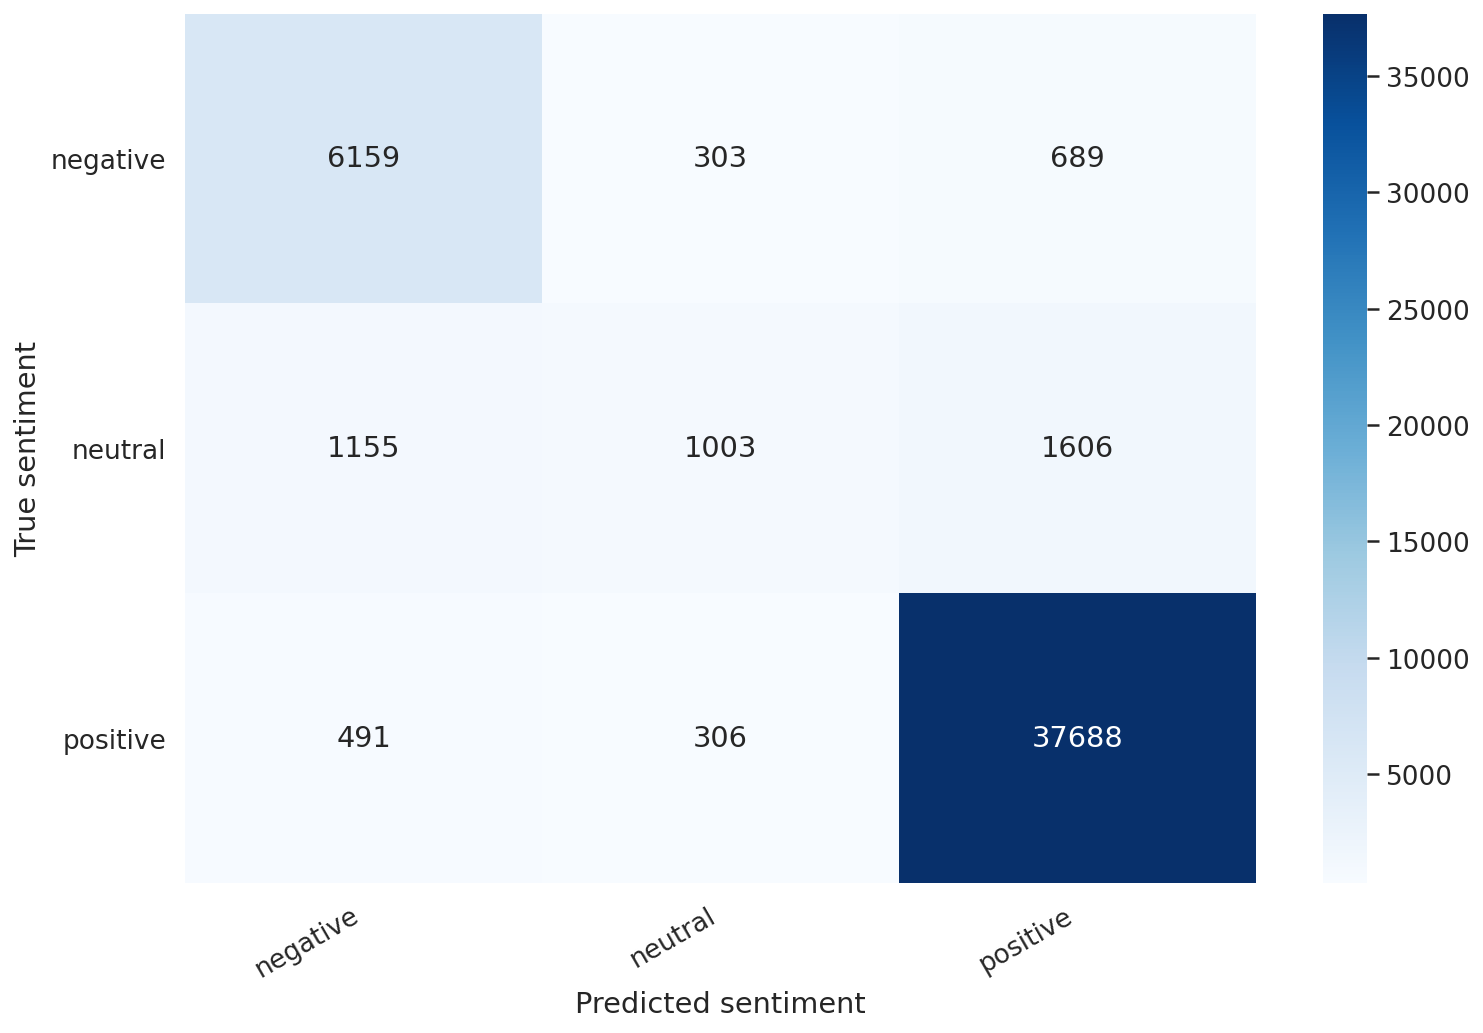

In [ ]:
## confusion matrix for BERT model
cm_b = confusion_matrix(y_test_b, y_pred_b)
df_cm_b = pd.DataFrame(cm_b, index=class_names, columns=class_names)
show_confusion_matrix(df_cm_b)

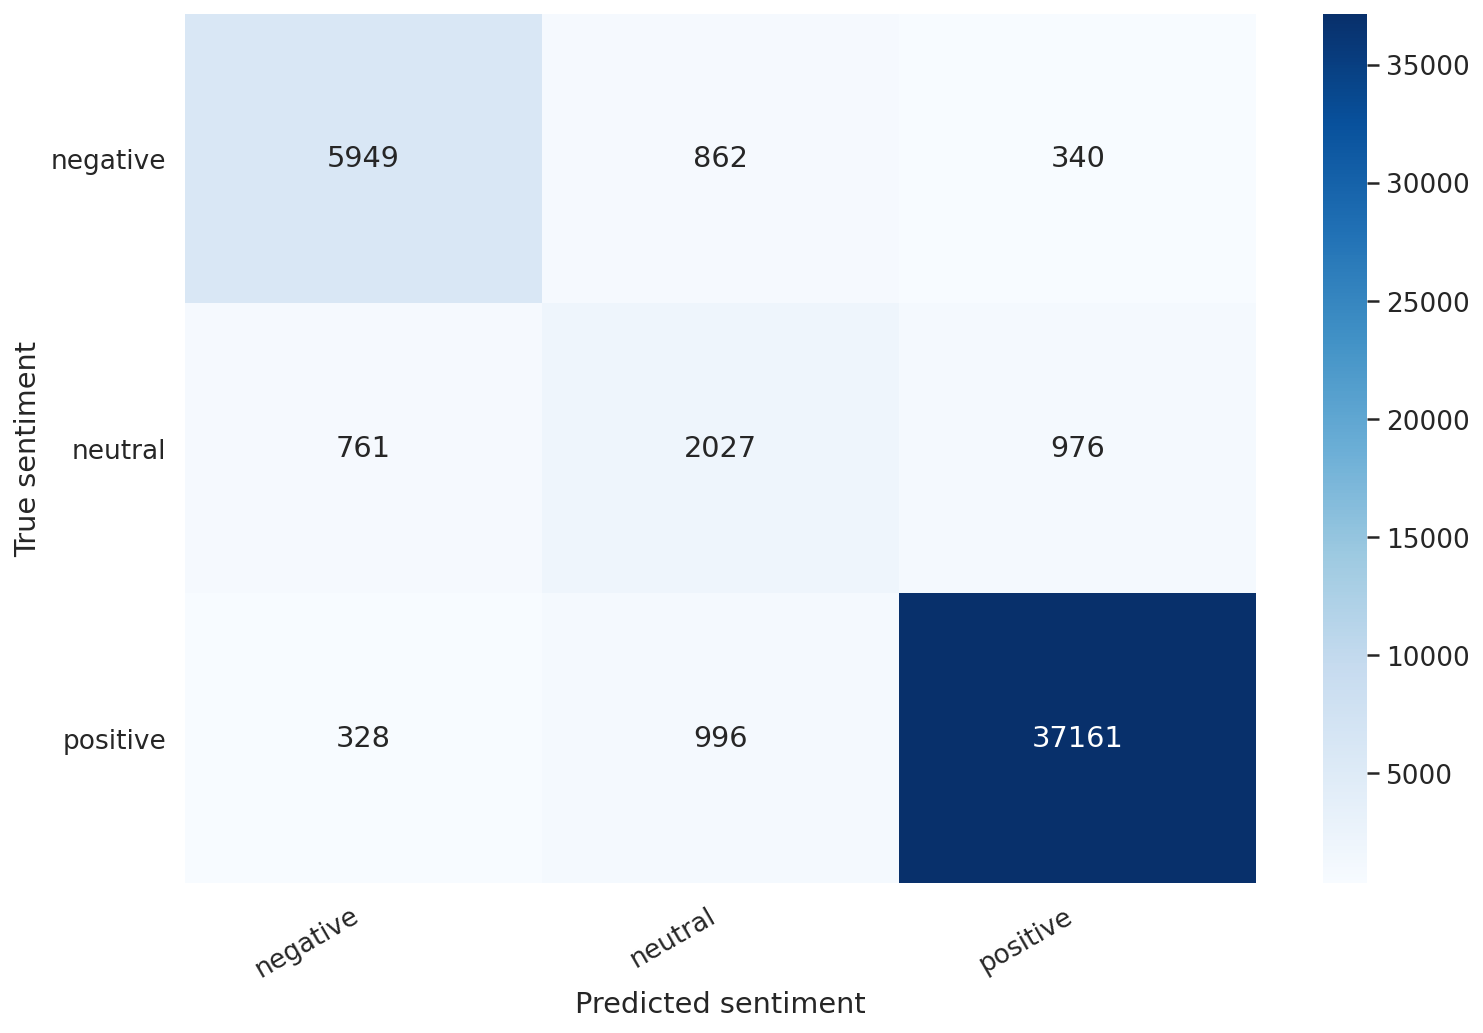

In [ ]:
## confusion matrix for roberta model
cm_r = confusion_matrix(y_test_r, y_pred_r)
df_cm_r = pd.DataFrame(cm_r, index=class_names, columns=class_names)
show_confusion_matrix(df_cm_r)

Let's use our models to predict the sentiment of some raw text. We will choose some financial reviews: positive, negative and neutral. We use data on this dataset.

In [ ]:
tmp = pd.read_csv('tmp.csv', encoding='latin-1',header=None, names=['sentiment','review'])

In [ ]:
tmp.head()

,sentiment,review
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
neutral_rev = tmp['review'][0]
pos_rev = tmp['review'][3]
neg_rev = tmp['review'][2]

### BERT

In [ ]:
encoded_neutral_rev_b=tokenizer_b.encode_plus(
      neutral_rev,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
encoded_pos_rev_b=tokenizer_b.encode_plus(
      pos_rev,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
encoded_neg_rev_b=tokenizer_b.encode_plus(
      neg_rev,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

In [ ]:
input_ids_n = encoded_neutral_rev_b['input_ids'].to(device)
attention_mask_n = encoded_neutral_rev_b['attention_mask'].to(device)

output = model_bert(input_ids_n, attention_mask_n)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {neutral_rev }')
print(f'Sentiment  : {class_names[prediction]}')

Review text: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sentiment  : positive


In [ ]:
input_ids_p = encoded_pos_rev_b['input_ids'].to(device)
attention_mask_p = encoded_pos_rev_b['attention_mask'].to(device)

output = model_bert(input_ids_p, attention_mask_p)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {pos_rev }')
print(f'Sentiment  : {class_names[prediction]}')

Review text: With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
Sentiment  : positive


In [ ]:
input_ids_neg = encoded_neg_rev_b['input_ids'].to(device)
attention_mask_neg = encoded_neg_rev_b['attention_mask'].to(device)

output = model_bert(input_ids_neg, attention_mask_neg)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {neg_rev }')
print(f'Sentiment  : {class_names[prediction]}')

Review text: The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .
Sentiment  : negative


### roberta

In [ ]:
encoded_neutral_rev_r=tokenizer_r.encode_plus(
            neutral_rev,
            None,
            truncation=True,
            padding='max_length',
            #strategy = 'truncation',
            add_special_tokens=True,
            max_length=MAX_LEN,
            #pad_to_max_length=True,
            return_token_type_ids=True,
            return_tensors='pt',
        )
encoded_pos_rev_r=tokenizer_r.encode_plus(
            pos_rev,
            None,
            truncation=True,
            padding='max_length',
            #strategy = 'truncation',
            add_special_tokens=True,
            max_length=MAX_LEN,
            #pad_to_max_length=True,
            return_token_type_ids=True,
            return_tensors='pt',
        )
encoded_neg_rev_r=tokenizer_r.encode_plus(
            neg_rev,
            None,
            truncation=True,
            padding='max_length',
            #strategy = 'truncation',
            add_special_tokens=True,
            max_length=MAX_LEN,
            #pad_to_max_length=True,
            return_token_type_ids=True,
            return_tensors='pt',
        )

In [ ]:
ids_n_r = encoded_neutral_rev_r['input_ids'].to(device, dtype = torch.long)
mask_n_r = encoded_neutral_rev_r['attention_mask'].to(device, dtype = torch.long)
token_type_ids_n_r = encoded_neutral_rev_r['token_type_ids'].to(device, dtype = torch.long)

outputs = model_ro(ids_n_r, mask_n_r, token_type_ids_n_r)
_, prediction = torch.max(outputs.data, dim=1)

print(f'Review text: {neutral_rev }')
print(f'Sentiment  : {class_names[prediction]}')

Review text: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sentiment  : positive


In [ ]:
ids_p_r = encoded_pos_rev_r['input_ids'].to(device, dtype = torch.long)
mask_p_r = encoded_pos_rev_r['attention_mask'].to(device, dtype = torch.long)
token_type_ids_p_r = encoded_pos_rev_r['token_type_ids'].to(device, dtype = torch.long)

outputs = model_ro(ids_p_r, mask_p_r, token_type_ids_p_r)
_, prediction = torch.max(outputs.data, dim=1)

print(f'Review text: {pos_rev }')
print(f'Sentiment  : {class_names[prediction]}')

Review text: With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
Sentiment  : positive


In [ ]:
ids_neg_r = encoded_neg_rev_r['input_ids'].to(device, dtype = torch.long)
mask_neg_r = encoded_neg_rev_r['attention_mask'].to(device, dtype = torch.long)
token_type_ids_neg_r = encoded_neg_rev_r['token_type_ids'].to(device, dtype = torch.long)

outputs = model_ro(ids_neg_r, mask_neg_r, token_type_ids_neg_r)
_, prediction = torch.max(outputs.data, dim=1)

print(f'Review text: {neg_rev }')
print(f'Sentiment  : {class_names[prediction]}')

Review text: The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .
Sentiment  : positive


## CHARACTER BERT and Medical CHARACTER BERT

In [ ]:
df_test_n,_ = train_test_split(df_test, test_size=0.95, stratify=df_test['sentiment'] ) ##test data for character BERT and medical Character BERT

In [ ]:
cd character-bert
from utils.character_cnn import CharacterIndexer
from modeling.character_bert import CharacterBertModel

In [ ]:
tokenizer_c = BertTokenizer.from_pretrained('bert-base-uncased')
X_test = df_test_n['Text'].tolist()
tokenized_test = [tokenizer.basic_tokenizer.tokenize(text) for text in X_test]

In [ ]:
indexer = CharacterIndexer()
tensor_test = indexer.as_padded_tensor(tokenized_test, maxlen=200)

In [ ]:
## batch
batch_size = 10
y_test = torch.tensor(df_test_n['sentiment'].values)
test_data = torch.utils.data.TensorDataset(tensor_test, y_test)
test_dataloader = DataLoader(test_data,batch_size=batch_size)

In [ ]:


## Load characterbert model
model_char = set_model()
model_char.load_state_dict(torch.load('best_model_state_char.bin'))
model_char = model_char.to(device)

## Load medical characterbert model
model_med = set_model(name='./pretrained-models/medical_character_bert/')
model_med.load_state_dict(torch.load('best_model_state_med_char.bin'))
model_med = model_med.to(device)

In [ ]:
##accuracy on test set for characterBERT
test_acc_char, _ = eval_char(
  model_char,
  test_dataloader,
  len(df_test_n),
)

print(test_acc_char)

##accuracy on test set for medical characterBERT
test_acc_med, _ = eval_char(
  model_med,
  test_dataloader,
  len(df_test_n),
)

print(test_acc_med)

0.8692307692307693
0.8647773279352227


In [ ]:
def get_predictions_char(model, data_loader):
  model = model.eval()
  
  #review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      batch = tuple(t.to(device) for t in d)
      b_input_ids, b_labels = batch
      outputs = model(b_input_ids)[0]

      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      #review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(b_labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
y_pred_char, y_pred_probs_char, y_test_char = get_predictions_char(
  model_char,
  test_dataloader,
)
y_pred_med, y_pred_probs_med, y_test_med = get_predictions_char(
  model_med,
  test_dataloader,
)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
print(classification_report(y_test_char, y_pred_char, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.69      0.74      0.71       358
     neutral       0.43      0.21      0.28       188
    positive       0.92      0.95      0.93      1924

    accuracy                           0.86      2470
   macro avg       0.68      0.63      0.64      2470
weighted avg       0.85      0.86      0.85      2470



In [ ]:
print(classification_report(y_test_med, y_pred_med, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.71      0.70      0.71       358
     neutral       0.33      0.31      0.32       188
    positive       0.93      0.94      0.93      1924

    accuracy                           0.86      2470
   macro avg       0.66      0.65      0.65      2470
weighted avg       0.85      0.86      0.85      2470



## metrics

In [7]:
results=[]

In [8]:
results.append([0.9, 0.91, 0.9])
results.append([0.91, 0.91, 0.91])
results.append([0.85, 0.86, 0.85])
results.append([0.85, 0.86, 0.85])


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
res = pd.DataFrame(results, columns=['accuracy', 'recall', 'F1-score'], index=['BERT', 'RoBERTa', 'gen Char', 'med char'])

In [16]:
res

,accuracy,recall,F1-score
BERT,0.90,0.91,0.90
RoBERTa,0.91,0.91,0.91
gen Char,0.85,0.86,0.85
med char,0.85,0.86,0.85


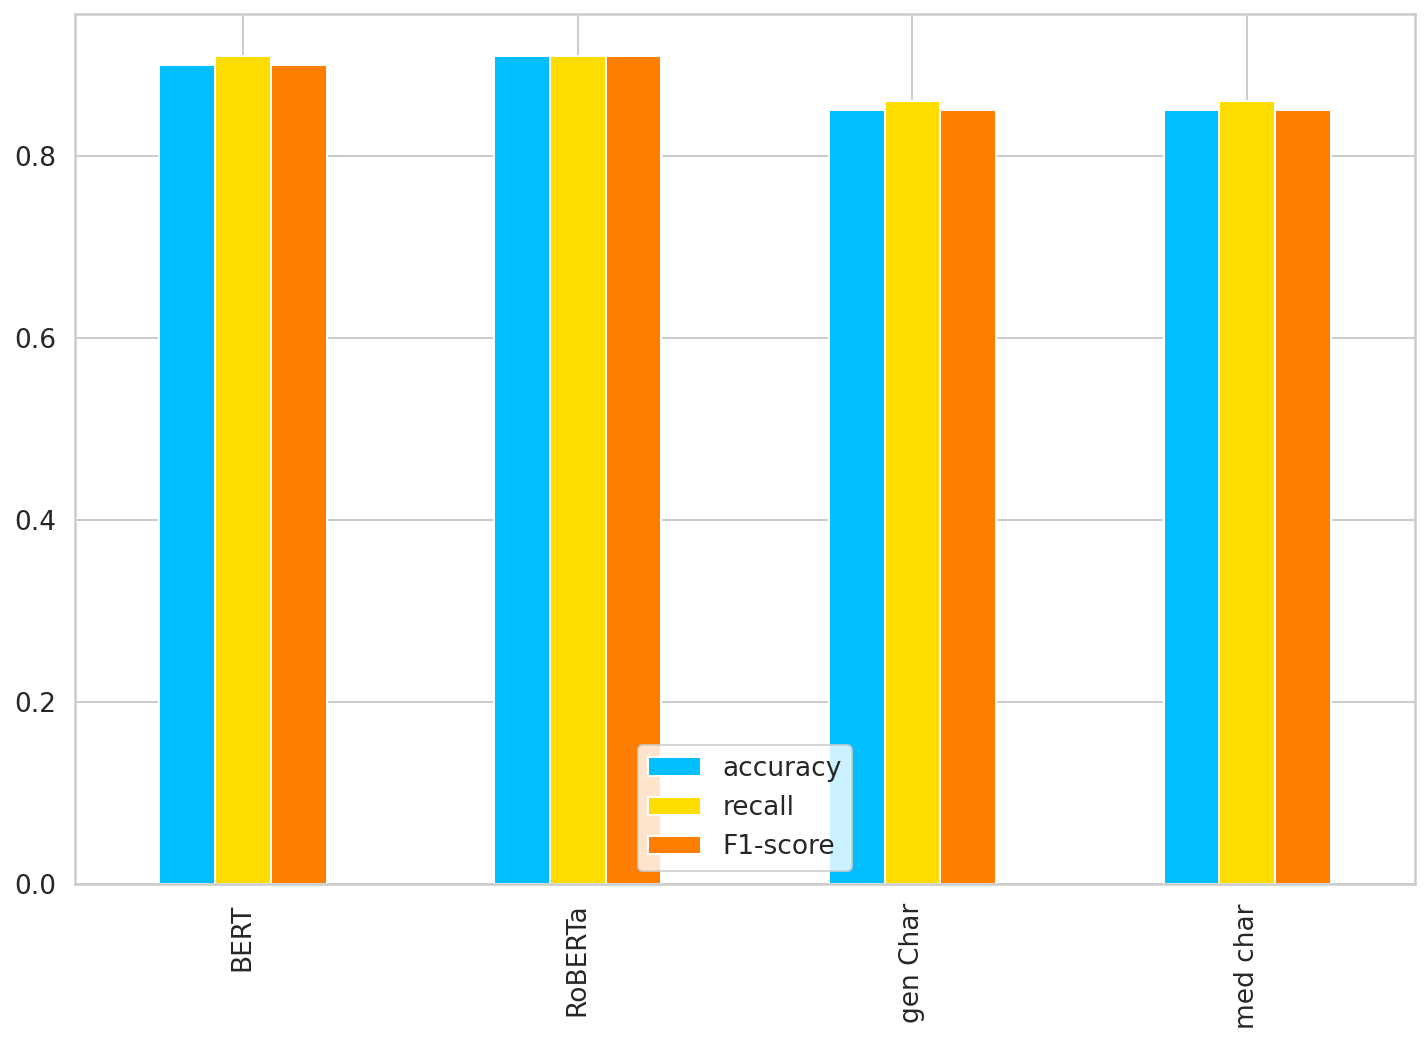

In [21]:
res.plot.bar()
plt.savefig('resultats.png')
plt.show()